In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

/tmp/ipykernel_8014/168312050.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-04 02:54:35.380346: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-04 02:54:36.384136: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2024-02-04 02:54:36.384289: I t

In [2]:
threshold = 1

# Check if predicted value is threshold amount above or below actual value
def is_in_threshold(actual, pred):
    return pred <= actual + threshold and pred >= actual - threshold

def create_tf_column(results):
    return results.apply(lambda x: is_in_threshold(x['y_test'], x['predictions']), axis=1)

def get_score(y_test, y_pred, **kwargs):
    dataframe = pd.DataFrame(y_test, columns=['y_test'])
    dataframe['predictions'] = y_pred
    return create_tf_column(dataframe).value_counts().get(True) / dataframe.shape[0]

In [3]:
random_state=1

In [4]:
# Import data and preprocess
df = pd.read_csv("../test_data/Grounded CPW Leaky Wave antenna/S11 Data.csv")
df = df.drop(df[df['dB(S(1,1)) []'] > 0].index) # Remove all rows with positive s11

# # Split into x and y
# input_x = df.drop(columns=['dB(S(1,1)) []'], axis=1)
# input_y = df[['dB(S(1,1)) []']]

# Split data into training and testing
train_df = df.sample(frac=0.8, random_state=0)
test_df = df.drop(train_df.index)
X_train = train_df.copy()
X_test = test_df.copy()
y_train = X_train.pop('dB(S(1,1)) []')
y_test = X_test.pop('dB(S(1,1)) []')

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1)) # Initialize scaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
import keras_tuner
class AntennaModel(keras_tuner.HyperModel):
    def __init__(self, input_shape):
        self.input_shape= input_shape
        
    def build(self, hp):
        model= keras.Sequential()
        
        # Tune the number of units in the first Dense layer
        # Defining dense units as a close approx to the original neural network to perform a fair comparision!
        
        
        hp_units_1= hp.Int('units_1', min_value=128, max_value= 160, step=32)
        hp_units_2= hp.Int('units_2', min_value=64, max_value= 128, step=32)
        hp_units_3= hp.Int('units_3', min_value=32, max_value= 64, step=16)

        model.add(keras.layers.Dense(units=hp_units_1, activation='relu', input_shape= self.input_shape))
        model.add(keras.layers.Dense(units=hp_units_2, activation='relu'))
        model.add(keras.layers.Dense(units=hp_units_3, activation='relu'))
        model.add(keras.layers.Dense(1))

        # Tune the learning rate for the optimizer 
        hp_learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=0.1, sampling='LOG', default= 0.0005)

        model.compile(loss='mse',
                    optimizer= keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    metrics= ['mae','mse']
                     )

        return model

In [7]:
import keras_tuner
antenna_model = AntennaModel(input_shape=[len(X_train.keys())])
tuner = keras_tuner.RandomSearch(
    antenna_model,
    objective='val_mse',
    max_trials=5)

tuner.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train_scaled, y_train, epochs=100, validation_split=0.2, validation_data = (X_test_scaled, y_test), callbacks=[stop_early])

Trial 5 Complete [00h 02m 18s]
val_mse: 21.557899475097656

Best val_mse So Far: 17.42557716369629
Total elapsed time: 00h 07m 02s


In [8]:
best_hps= tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

In [9]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is {best_hps.get('units_1')}  

and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# Evaluate the best model.
print(best_model.metrics_names)
loss, mae, mse = best_model.evaluate(X_test, y_test)
print(f'loss:{loss} mae: {mae} mse: {mse}')


The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is 128  

and the optimal learning rate for the optimizer
is 0.013230581599608158.

[]
25/27 [==========================>...] - ETA: 0s - loss: 155.8861 - mae: 9.7643 - mse: 155.8861

2024-02-04 03:01:43.913655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-04 03:01:43.942532: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-04 03:01:43.942592: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 12057 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


27/27 [==============================] - 0s 6ms/step - loss: 156.8217 - mae: 9.7628 - mse: 156.8217
loss:156.8217010498047 mae: 9.762840270996094 mse: 156.8217010498047


In [10]:
best_model.save("dnn.h5")

In [11]:
# best_model = tf.keras.models.load_model("dnn.h5")

In [12]:
best_model.predict(X_test_scaled)

27/27 [==============================] - 0s 2ms/step


2024-02-04 03:01:44.321092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-04 03:01:44.399719: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-04 03:01:44.399791: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 12057 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-02-04 03:01:44.412745: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-04 03:01:44.412805: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

array([[ -2.5289001 ],
       [ -2.4957316 ],
       [ -2.393941  ],
       [ -1.9466511 ],
       [ -0.7427908 ],
       [ -0.7805551 ],
       [ -0.8245351 ],
       [ -0.86851555],
       [ -0.9564762 ],
       [ -6.974612  ],
       [-11.625107  ],
       [-11.625107  ],
       [-11.625107  ],
       [-11.625107  ],
       [-11.625107  ],
       [-11.625107  ],
       [-10.567892  ],
       [-10.0792885 ],
       [ -7.878352  ],
       [ -5.5202923 ],
       [ -4.9889383 ],
       [ -4.878449  ],
       [ -5.8899384 ],
       [ -9.1326    ],
       [-12.917801  ],
       [-14.045975  ],
       [-14.497246  ],
       [-14.834694  ],
       [-14.770971  ],
       [-14.749731  ],
       [-14.707252  ],
       [-14.686008  ],
       [-14.664768  ],
       [-14.537326  ],
       [-14.500494  ],
       [-14.578253  ],
       [-15.387341  ],
       [-15.482527  ],
       [ -2.448835  ],
       [ -1.9233526 ],
       [ -1.659038  ],
       [ -0.7427908 ],
       [ -0.7427908 ],
       [ -0

In [14]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=False)
dnn_model = tuner.hypermodel.build(best_hps)
history_tuned= dnn_model.fit(X_train_scaled, y_train, 
          epochs = 100, 
          validation_data = (X_test_scaled, y_test),
          verbose=1,
          callbacks= early_stopping_cb)

print("\n Using Early stopping, needed only ",len(history_tuned.history['val_mse']),"epochs to converge!")

Epoch 1/100
 11/106 [==>...........................] - ETA: 1s - loss: 81.6036 - mae: 6.9290 - mse: 81.6036   

2024-02-04 03:02:32.570691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-04 03:02:32.624375: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-04 03:02:32.624428: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 12057 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


106/106 [==============================] - 2s 12ms/step - loss: 31.8498 - mae: 4.2078 - mse: 31.8498 - val_loss: 29.1565 - val_mae: 3.5947 - val_mse: 29.1565
Epoch 2/100
  6/106 [>.............................] - ETA: 1s - loss: 22.5797 - mae: 3.4744 - mse: 22.5797

2024-02-04 03:02:33.832490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-04 03:02:33.856263: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-04 03:02:33.856339: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 12057 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


106/106 [==============================] - 1s 12ms/step - loss: 24.5243 - mae: 3.7188 - mse: 24.5243 - val_loss: 30.7478 - val_mae: 3.6464 - val_mse: 30.7478
Epoch 3/100
106/106 [==============================] - 1s 12ms/step - loss: 22.2256 - mae: 3.4667 - mse: 22.2256 - val_loss: 27.6080 - val_mae: 3.4907 - val_mse: 27.6080
Epoch 4/100
106/106 [==============================] - 1s 12ms/step - loss: 21.3870 - mae: 3.3730 - mse: 21.3870 - val_loss: 37.1166 - val_mae: 4.9421 - val_mse: 37.1166
Epoch 5/100
106/106 [==============================] - 1s 12ms/step - loss: 21.5775 - mae: 3.3900 - mse: 21.5775 - val_loss: 24.9725 - val_mae: 3.3260 - val_mse: 24.9725
Epoch 6/100
106/106 [==============================] - 1s 12ms/step - loss: 19.3888 - mae: 3.1779 - mse: 19.3888 - val_loss: 24.9539 - val_mae: 3.2100 - val_mse: 24.9539
Epoch 7/100
106/106 [==============================] - 1s 11ms/step - loss: 18.9661 - mae: 3.1142 - mse: 18.9661 - val_loss: 28.7065 - val_mae: 3.5170 - val_mse: 

In [ ]:
import pickle
with open("dnn.pkl", "wb") as file:
    pickle.dump(history_tuned, file)

# with open("dnn.pkl", "rb") as file:
#     history_tuned = pickle.load(file)

INFO:tensorflow:Assets written to: ram://92706c91-cc33-431d-8142-0db7035888c4/assets


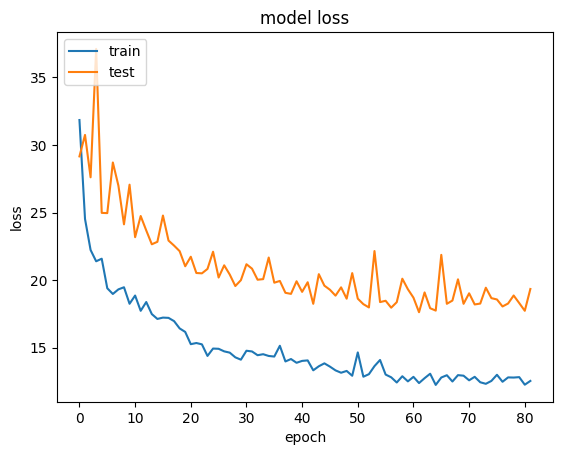

<Figure size 640x480 with 0 Axes>

In [16]:
plt.plot(history_tuned.history['loss'])
plt.plot(history_tuned.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("validation_loss.png")
plt.show()

In [ ]:
test_results = best_model.evaluate(X_test, y_test, verbose=0)

In [ ]:
test_results

In [ ]:
test_predictions = best_model.predict(X_test_scaled).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

plt.axline((-30,-30), (10,10))
plt.show()
# lims = [0, 50]
# plt.xlim(lims)
# plt.ylim(lims)
# _ = plt.plot(lims, lims)

In [ ]:
error = test_predictions - y_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler

model = DecisionTreeRegressor(random_state=random_state) # Initialize model
scaler = MinMaxScaler(feature_range=(0,1)) # Initialize scaler
pipeline = Pipeline(steps=[('normalize', scaler), ('model', model)]) # Create pipeline with scaler and model
pipeline_fit = pipeline.fit(X_train, y_train)
sklearn_predictions = pipeline_fit.predict(X_test)

In [ ]:
print(f"tensorflow score: {get_score(y_test.values.ravel(), test_predictions)}")
print(f"sklearn score: {get_score(y_test.values.ravel(), sklearn_predictions)}")

In [ ]:
analysis_df = X_test.copy()
analysis_df['dB(S(1,1)) []'] = y_test
analysis_df['tensorflow predicted s11'] = test_predictions
analysis_df['sklearn predicted s11'] = sklearn_predictions

In [ ]:
analysis_df

In [ ]:
what  = pd.concat([df, analysis_df])

In [ ]:
# what['tensorflow predicted s11'] = what['tensorflow predicted s11'].fillna(what['dB(S(1,1)) []'])
# what['sklearn predicted s11'] = what['sklearn predicted s11'].fillna(what['dB(S(1,1)) []'])

In [ ]:
import plotly.express as px

geometry = analysis_df.drop(['dB(S(1,1)) []', 'tensorflow predicted s11', 'sklearn predicted s11', 'Freq [GHz]'], axis=1).iloc[700]
geometry_filter = geometry.to_dict()

# Get all entries with all frequencies for this geometry 
matches = what.loc[(what[list(geometry_filter)] == pd.Series(geometry_filter)).all(axis=1)]

fig = px.line(matches.sort_values("Freq [GHz]"), x="Freq [GHz]", y=["dB(S(1,1)) []", 'tensorflow predicted s11', 'sklearn predicted s11'])

In [ ]:
fig.show()